In [1]:
import time
from ML4transients.data_access import DatasetLoader
from ML4transients.training import PytorchDataset
import pandas as pd
import numpy as np

print("Loading dataset...")
t0 = time.time()
dataset = DatasetLoader('/sps/lsst/groups/transients/HSC/fouchez/raphael/data/UDEEP')
print(f"Dataset loaded in {time.time() - t0:.2f} seconds")


2025-09-17 14:08:24.945293: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758110905.307720 3999036 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758110905.367723 3999036 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758110906.173454 3999036 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758110906.173483 3999036 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758110906.173485 3999036 computation_placer.cc:177] computation placer alr

Loading dataset...
Dataset loaded in 0.08 seconds


# Cutouts


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

first_visit = dataset.visits[0]
print(f"Loading cutouts from visit {first_visit}")

cutout_loader = dataset.cutouts[first_visit]
feature_loader = dataset.features[first_visit]
sample_ids = cutout_loader.ids[:6]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, dia_id in enumerate(sample_ids):
    cutout = cutout_loader.get_by_id(dia_id)
    features = feature_loader.get_by_id(dia_id)
    is_injection = features['is_injection'].iloc[0] if not features.empty else False
    
    im = axes[i].imshow(cutout, cmap='RdYlGn', origin='lower')
    axes[i].set_title(f'ID: {dia_id}\nInjection: {is_injection}')
    axes[i].axis('off')
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

print(f"Cutout shape: {cutout.shape}")
print(f"Value range: [{cutout.min():.3f}, {cutout.max():.3f}]")

# LC visualization

In [1]:
dataset.lightcurves.plot_lightcurve(dia_object_id=3496046754095217818)

NameError: name 'dataset' is not defined

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np

first_visit = dataset.visits[0]
sample_dia_source_id = dataset.cutouts[first_visit].ids[10]

print(f"Performance comparison for diaSourceId: {sample_dia_source_id}")
print("=" * 60)

# Method 1: Lightcurve only
print("\nMethod 1: Lightcurve columns only")
start_time = time.time()
data_lc_only = dataset.get_complete_lightcurve_data(sample_dia_source_id, load_cutouts=False)
time_lc_only = time.time() - start_time

if data_lc_only:
    print(f"Success: {data_lc_only['num_sources']} sources, {len(data_lc_only['lightcurve'])} LC points")
    print(f"Time: {time_lc_only:.3f}s")
else:
    print("Failed")

print("-" * 60)

# Method 2: Lightcurve + cutouts
print("\nMethod 2: Lightcurve + cutouts")
start_time = time.time()
data_full = dataset.get_complete_lightcurve_data(sample_dia_source_id, load_cutouts=True)
time_full = time.time() - start_time

if data_full:
    print(f"Success: {data_full['num_sources']} sources, {len(data_full['cutouts'])} cutouts")
    print(f"Time: {time_full:.3f}s")
else:
    print("Failed")

print("=" * 60)

# Performance summary
if data_lc_only and data_full:
    speedup = time_full / time_lc_only
    print(f"\nSpeedup: {speedup:.1f}x faster (lightcurve-only)")
    print(f"Time saved: {time_full - time_lc_only:.3f}s")

In [ ]:
# Plot all cutouts
if data_full and data_full['cutouts']:
    cutouts = data_full['cutouts']
    lightcurve = data_full['lightcurve']
    
    # Sort by time if available
    if 'diaSourceId' in lightcurve.columns and 'midpointMjdTai' in lightcurve.columns:
        time_map = dict(zip(lightcurve['diaSourceId'], lightcurve['midpointMjdTai']))
        sorted_ids = sorted(cutouts.keys(), key=lambda x: time_map.get(x, 0))
    else:
        sorted_ids = list(cutouts.keys())
    
    n_cutouts = len(cutouts)
    cols = min(8, n_cutouts)
    rows = (n_cutouts + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))
    if n_cutouts == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for i, src_id in enumerate(sorted_ids):
        im = axes[i].imshow(cutouts[src_id], cmap='RdYlGn', origin='lower')
        axes[i].axis('off')
        plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
    
    for i in range(n_cutouts, len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle(f'Cutouts for object {data_full["object_id"]} ({n_cutouts} total)')
    plt.tight_layout()
    plt.show()
else:
    print("No cutouts available")

# Lc inference

Discovering data files...
Data discovery completed in 0.01s: 862 cutout visits, 862 feature visits, 1 lightcurve paths
Loaded SNN inference data: 3856539 total lightcurves
  SNN processed: 489 lightcurves
  Not processed (failed filtering): 3856050 lightcurves
  Processing rate: 0.0%

SNN Inference Source Count Statistics:
  Mean sources per lightcurve: 17.7
  Min sources: 10
  Max sources: 116

VALIDATING SNN FILTERING CONSISTENCY
Checking 100 SNN-processed lightcurves against filtering criteria...
Loaded lightcurve index with 3856539 objects
These objects have SNN results but don't meet filtering criteria:
  • 3495848842002207424: 9/14 pts in window, SNN used 13 pts
  • 3495862036141735228: 5/11 pts in window, SNN used 10 pts
  • 3495892822467314205: 8/13 pts in window, SNN used 11 pts

RECOMMENDATION: Re-run the SNN pipeline to ensure consistent filtering!


SNN-processed objects: 489
Non-SN: 20 (4.1%)
Supernova: 469 (95.9%)

Uncertainty Statistics:
Mean SN probability uncertainty: 

/sps/lsst/users/rbonnetguerrini/ML4transients/src/ML4transients/data_access/data_loaders.py:1638: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


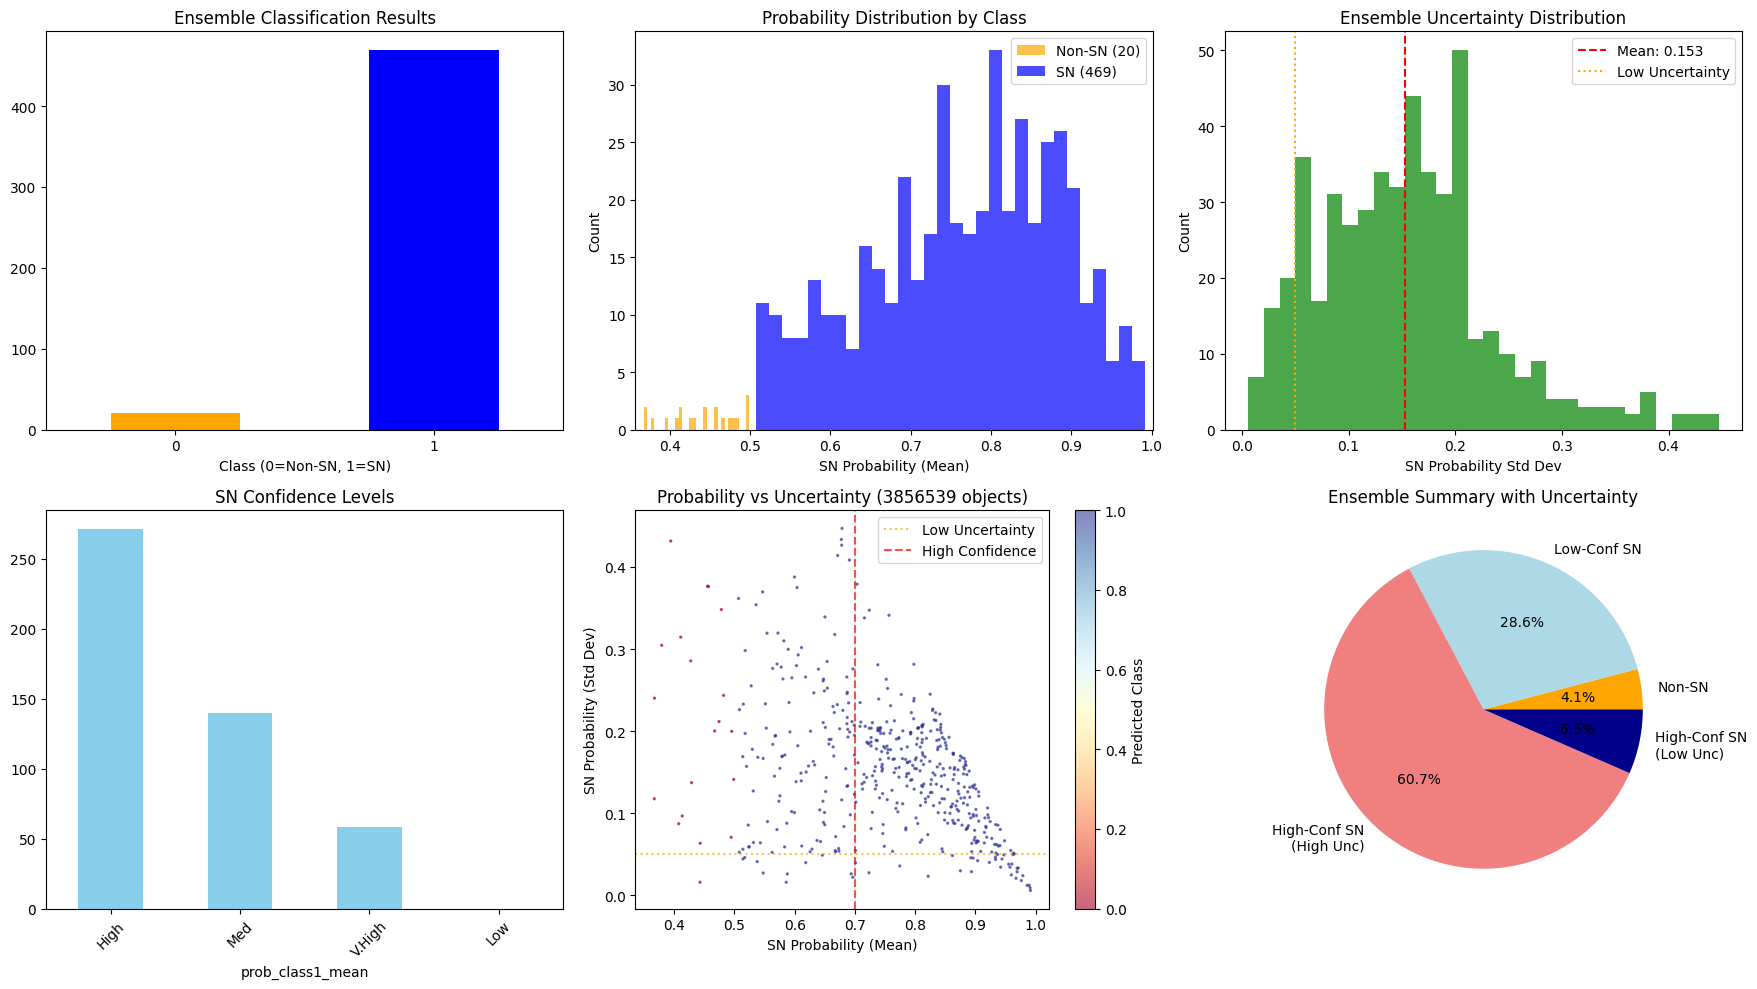


Ensemble Summary:
SNN-processed objects: 3856539
Total objects in dataset: 3856539
High-confidence SN candidates: 329
High-conf + Low uncertainty: 32
Mean uncertainty: 0.153
Objects with high uncertainty (>0.1): 350


In [2]:
r = dataset.lightcurves.inference_snn

In [3]:
for i, (_, row) in enumerate(r.iterrows(), 1):
    print(f"{str(int(row['diaObjectId']))}")

3496046754095217818
3495901618560353722
3495963191211497507
3495848842002204206
3496002773630105195
3496011569723114382
3495853240048707626
3496007171676607251
3495910414653359589
3496024763862652160
3496007171676607177
3495967589258005494
3496033559955712391
3495985181444047538
3495853240048704850
3496007171676616368
3495949997071971839
3495971987304539225
3495848842002209632
3496099530653305638
3495976385351016718
3496099530653325498
3496011569723113981
3495967589257999199
3496051152141716680
3495853240048704323
3495963191211497851
3495941200978940809
3496064346281240533
3496029161909182824
3496086336513796240
3495897220513822327
3495985181444047294
3495910414653355215
3496051152141716619
3495906016606839094
3496020365816150213
3495892822467318088
3495906016606838787
3495910414653356246
3495906016606839883
3495989579490564029
3496033559955739927
3495967589258005654
3496024763862652643
3495936802932415595
3495932404885913083
3495945599025479796
3496046754095204400
3496064346281241708


Found 87 high-confidence diaObjectId candidates.
Total high-confidence diaSourceIds found: 2434


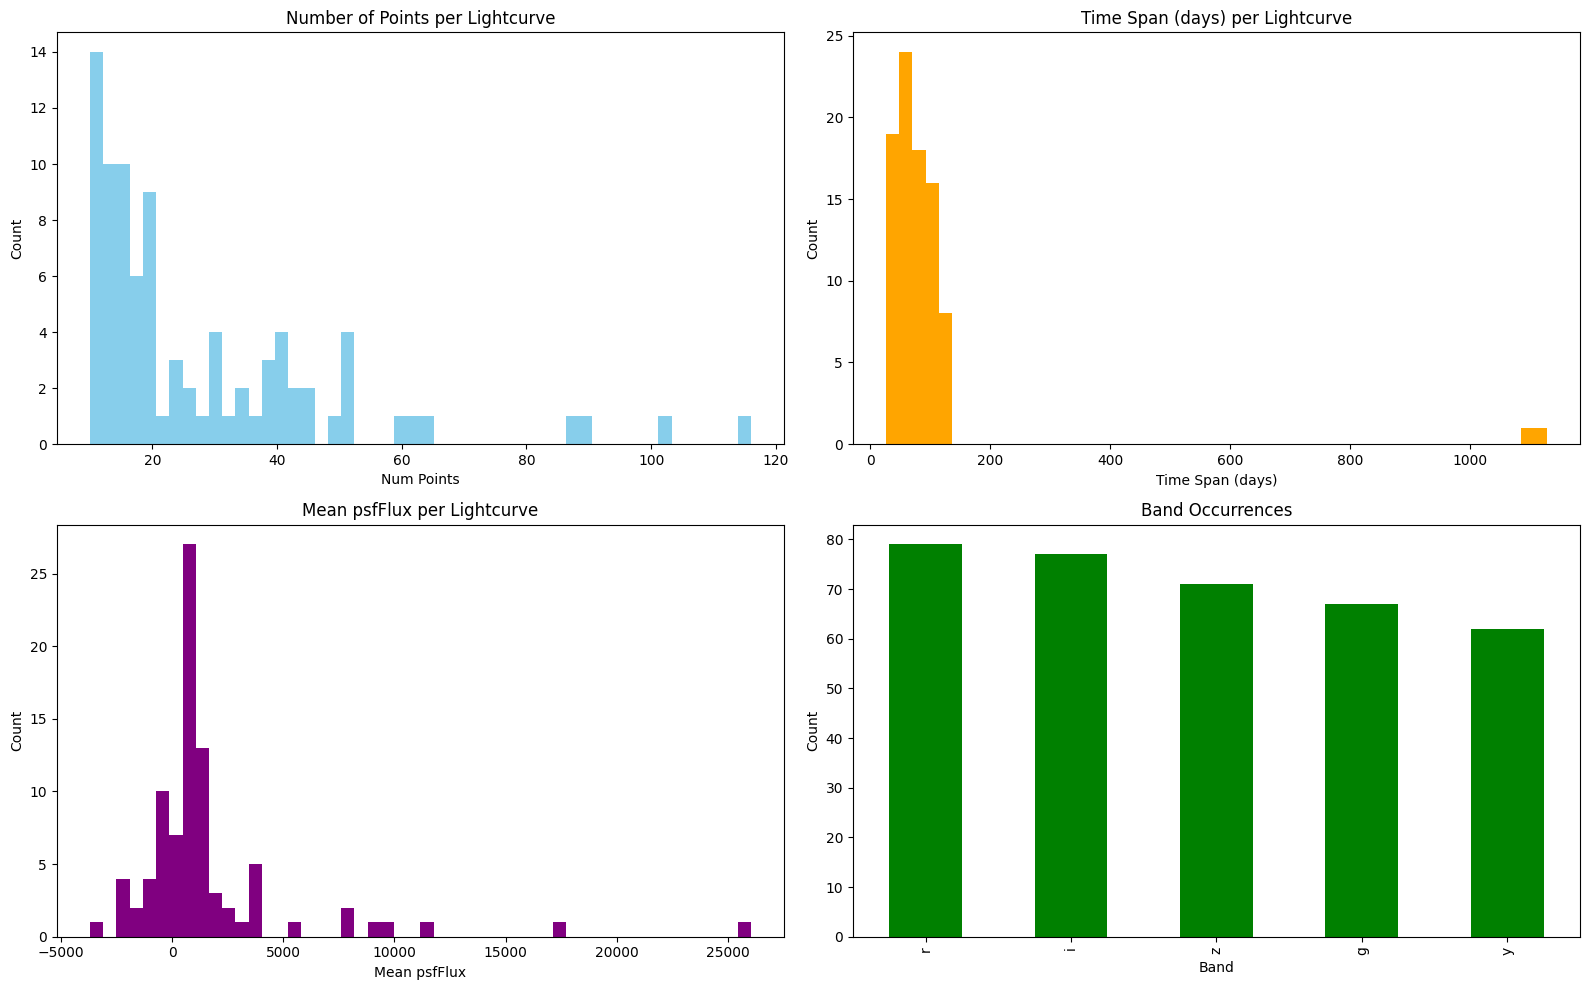

{'num_lightcurves': 87, 'num_points': {'mean': 27.977011494252874, 'median': 19.0, 'std': 20.953137098945927, 'min': 10, 'max': 116}, 'time_span_days': {'mean': 97.45239991865013, 'median': 70.91577719907218, 'std': 158.29065661053303, 'min': 26.0359696874948, 'max': 1127.902769953711}, 'mean_psf_flux': {'mean': 1637.19429891922, 'median': 726.4179220891764, 'std': 4016.7792785566817, 'min': -3693.8077353326335, 'max': 26038.366907915002}, 'bands': {'unique': ['g', 'i', 'y', 'z', 'r'], 'counts': {'r': 79, 'i': 77, 'z': 71, 'g': 67, 'y': 62}}}


In [4]:
high_conf = list(dataset.lightcurves.get_high_conf_sn_sources(prob_threshold=0.8, std_threshold=0.1))

diasource_index = dataset.lightcurves.diasource_index
# This will get the unique diaObjectIds corresponding to your high-confidence sources
high_conf_obj_ids = list(set(diasource_index.loc[
    diasource_index.index.isin(high_conf), 'diaObjectId'
]))

stats_dict = dataset.lightcurves.summarize_multiple_lightcurves(high_conf_obj_ids)
print(stats_dict)

In [5]:
dataset.lightcurves.save_high_conf_subset_dataset("/sps/lsst/groups/transients/HSC/fouchez/raphael/data/UDEEP_norm_high_conf_smallv4", prob_threshold=0.8, std_threshold=0.1)

Found 87 high-confidence diaObjectId candidates.
Total high-confidence diaSourceIds found: 2434
Saving 2434 high-confidence SN sources to mini-dataset.
Saved filtered lightcurve_index.h5: 87 entries
Saved filtered diasource_patch_index.h5: 2434 entries
No high-confidence sources found in patch_9813_9.h5
No high-confidence sources found in patch_9813_2.h5
No high-confidence sources found in patch_9813_52.h5
No high-confidence sources found in patch_9813_75.h5
No high-confidence sources found in patch_9813_40.h5
No high-confidence sources found in patch_9813_24.h5
No high-confidence sources found in patch_9813_20.h5
No high-confidence sources found in patch_9813_38.h5
No high-confidence sources found in patch_9813_21.h5
No high-confidence sources found in patch_9813_18.h5
No high-confidence sources found in patch_9813_71.h5
No high-confidence sources found in patch_9813_79.h5
No high-confidence sources found in patch_9813_42.h5
No high-confidence sources found in patch_9813_41.h5
No high